In [166]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

In [167]:
#torch data set
class dataSetAll(Dataset):
    def __init__(self, yearLow, yearHigh,numFeat,numOut):
        #import data from CDC
        self.df = pd.read_csv("data\FluViewPhase2Data\WHO_NREVSS_Combined_prior_to_2015_16.csv")
        self.df = self.df[(yearLow <= self.df["YEAR"]) & (self.df["YEAR"] < yearHigh)]["TOTAL"]
        #turn data into features and output
        #features: 5 previous + one from last year for predicted
        #output: prediction for next time

        #create test data
        self.numFeat = numFeat #------------------------
        self.numOut = numOut
        self.data = np.asarray(self.df,dtype=np.float32)
        self.data = torch.as_tensor(self.data)

    def __len__(self):
        return len(self.data)-self.numFeat-self.numOut
    
    def __getitem__(self,idx):
        return self.data[idx:idx+self.numFeat],self.data[idx+self.numFeat:idx+self.numFeat+self.numOut]

In [168]:
#create data loaders
numFeat = 10
numOut = 1
train_data = dataSetAll(1900,2013,numFeat,numOut)
test_data = dataSetAll(2013,2100,numFeat,numOut)
train_dataloader = DataLoader(train_data, batch_size=64,drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=64,drop_last=True)
# print(train_data[0])

In [169]:
# create our RNN based network with an RNN followed by a linear layer
inputSize = 1
sequenceLength = numFeat
numLayers = 1
hiddenSize = 64
batchSize = 64

class RNN(nn.Module):
    def __init__(self, inputSize, hiddenSize, numLayers, numOut, sequenceLength=1):
        super(RNN, self).__init__()
        self.numOut = numOut
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize
        self.numLayers = numLayers
        self.RNN = nn.RNN(inputSize,hiddenSize,numLayers,nonlinearity='relu',batch_first=True)
        self.fc = nn.Linear(hiddenSize*sequenceLength,numOut)
        
    def forward(self,x):
        h0 = torch.zeros(self.numLayers,x.size(0),self.hiddenSize)
        out, _ = self.RNN(x,h0)
        out = self.fc(out[:,-1,:])
        return out

model = RNN(inputSize,hiddenSize,numLayers,numOut)

In [170]:
#train/test loop
def train_loop(dataloader, model, loss_fn, optimizer,t):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X[:,:,None]
        # print(X.size())
        pred = model(X)
        loss = loss_fn(pred, y)
        # print("pred",pred)
        # print("Y",y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        if batch % size == 0:
            # loss, current = loss.item(), batch * len(X)
            print(f"loss({t}): {loss.item():>7f}")

In [171]:
learning_rate = .001
batch_size = 64
epochs = 500
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# print(list(model.parameters()))
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer,t)
    # test_loop(test_dataloader, model, loss_fn)

print("Done!")
# print(list(model.parameters()))

loss(0): 9748687.000000
loss(1): 8646762.000000
loss(2): 7618943.000000
loss(3): 5351542.000000
loss(4): 2414522.500000
loss(5): 2443549.750000
loss(6): 2188564.000000
loss(7): 1764845.125000
loss(8): 1996156.375000
loss(9): 1456080.375000
loss(10): 1359260.375000
loss(11): 1192705.000000
loss(12): 1075783.625000
loss(13): 1020100.687500
loss(14): 1032709.750000
loss(15): 849874.000000
loss(16): 799054.750000
loss(17): 819445.437500
loss(18): 1148941.750000
loss(19): 681502.062500
loss(20): 613307.687500
loss(21): 572894.187500
loss(22): 543502.687500
loss(23): 518605.968750
loss(24): 496301.250000
loss(25): 475907.812500
loss(26): 462669.312500
loss(27): 446758.906250
loss(28): 437097.781250
loss(29): 423376.093750
loss(30): 465397.437500
loss(31): 416781.531250
loss(32): 493761.968750
loss(33): 728205.000000
loss(34): 447814.781250
loss(35): 388812.750000
loss(36): 378776.312500
loss(37): 358550.156250
loss(38): 353336.468750
loss(39): 343697.156250
loss(40): 343023.531250
loss(41): 

KeyboardInterrupt: 

c:\Users\mburs\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Users\mburs\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


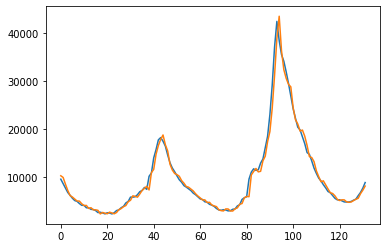

In [172]:
def test_loop(dataloader, model):
    yearLow = 2013
    yearHigh = 2020
    df = pd.read_csv("data\FluViewPhase2Data\WHO_NREVSS_Combined_prior_to_2015_16.csv")
    df = df[(yearLow <= df["YEAR"]) & (df["YEAR"] < yearHigh)]["TOTAL"]
    data = np.array(df)
    numFeat = 10 #------------------------
    numOut = 1

    size = len(data)-numFeat-numOut
    
    with torch.no_grad():
        for idx in range(4,len(test_data)):
            feat = test_data[idx][0]
            y = test_data[idx][1]
            X = feat[None,:,None]
            pred = model(X).squeeze().numpy()
            plt.plot(np.append(feat,pred))
            plt.plot(np.append(feat,y))
            
            plt.show()

def graph(model):
    with torch.no_grad():
        predY = []
        actY = []
        for idx in range(len(test_data)):
            feat = test_data[idx][0]
            y = test_data[idx][1]
            X = feat[None,:,None]
            pred = model(X).squeeze().numpy()
            predY.append(pred)
            actY.append(y)
            # plt.plot(np.append(feat,pred))
            # plt.plot(np.append(feat,y))
            
            
        
        plt.plot(actY) 
        plt.plot(predY)
        plt.show()

# test_loop(test_dataloader,model)
graph(model)
